In [3]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import nb_eval.matplotlib_functions as mympf

sys.path.append("/cerea_raid/users/dumontj/dev/coco2/dl")

sys.path.append("/cerea_raid/users/dumontj/dev/coco2/data_build")
import ddeq
import coco2_data_config

%load_ext lab_black

ModuleNotFoundError: No module named 'nb_eval'

In [2]:
def get_raw_smartcarb_grid_coords() -> dict:
    """Get raw smartcarb grid points coordinates (longitude/latitude)."""
    dir_raw_smartcarb_xco2_data = os.path.join(
        coco2_data_config.raw_data_dir, "smartcarb", "cosmo2D"
    )

    cosmo_2d_file = os.path.join(
        dir_raw_smartcarb_xco2_data, f"cosmo_2d_{2015:01}{5:02}{10:02}{10:02}.nc"
    )
    ds = xr.open_dataset(
        cosmo_2d_file,
        decode_times=False,
    )
    return {"lons": ds.lon.values, "lats": ds.lat.values}


def get_source_coords(name_source: str) -> dict:
    """Get source coordinates (longitude/latitude)."""
    sources = ddeq.misc.read_point_sources()
    source = sources.sel(source=name_source)
    return {"lon": float(source["lon_o"]), "lat": float(source["lat_o"])}


def get_closest_grid_point_indices(grid_coords: dict, source_coords: dict):
    """Get point in grid_coords closest from source_coords indices."""
    dist_to_source = np.abs(grid_coords["lons"] - source_coords["lon"]) + np.abs(
        grid_coords["lats"] - source_coords["lat"]
    )
    source_y_grid_point, source_x_grid_point = np.unravel_index(
        dist_to_source.argmin(), dist_to_source.shape
    )

    return {"y": source_y_grid_point, "x": source_x_grid_point}


def crop_around_source(
    input_array: np.ndarray, Ny: int, Nx: int, name_source: str
) -> np.ndarray:
    """Crop SMARTCARB images around a specified source."""
    raw_sc_coords = get_raw_smartcarb_grid_coords()
    source_coords = get_source_coords(name_source)
    source_grid_point = get_closest_grid_point_indices(raw_sc_coords, source_coords)

    if len(input_array.shape) == 2:
        output_array = input_array[
            source_grid_point["y"] - int(Ny / 2) : source_grid_point["y"] + int(Ny / 2),
            source_grid_point["x"] - int(Nx / 2) : source_grid_point["x"] + int(Nx / 2),
        ]
    elif len(input_array.shape) == 3:
        output_array = input_array[
            :,
            source_grid_point["y"] - int(Ny / 2) : source_grid_point["y"] + int(Ny / 2),
            source_grid_point["x"] - int(Nx / 2) : source_grid_point["x"] + int(Nx / 2),
        ]
    else:
        print("Wrong input_array dimension")

    return output_array


def random_dates(start, end, unit="D", seed=None):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    ndays = (end - start).days + 1
    return (pd.to_timedelta(np.random.rand(1) * ndays, unit=unit) + start)[0]

# SMARTCARB

In [ ]:
ds_raw_smartcarb = xr.open_dataset(
    "/libre/dumontj/coco2/raw_data/smartcarb/cosmo2D/raw_smartcarb_data.nc"
)
emissions = pd.read_csv(
    "/libre/dumontj/coco2/raw_data/smartcarb/timeseries/ts_CO2_emissions.dat",
    sep="\t",
    index_col=0,
    parse_dates=True,
)

In [7]:
ds_raw_smartcarb

<xarray.Dataset>
Dimensions:      (rlon: 700, rlat: 600, t: 8593)
Coordinates:
  * rlon         (rlon) float64 -1.4 -1.39 -1.38 -1.37 ... 5.56 5.57 5.58 5.59
  * rlat         (rlat) float64 2.5 2.51 2.52 2.53 2.54 ... 8.46 8.47 8.48 8.49
  * t            (t) datetime64[ns] 2015-01-01 ... 2015-12-25
Data variables:
    XCO2_BV      (t, rlat, rlon) float32 ...
    XCO2_JV      (t, rlat, rlon) float32 ...
    NO2_BV       (t, rlat, rlon) float32 ...
    NO2_JV       (t, rlat, rlon) float32 ...
    XCO2_TOT_BG  (t, rlat, rlon) float32 ...
    NO2_TOT_BG   (t, rlat, rlon) float32 ...
Attributes:
    DATE CREATED:  Thu Mar 22 12:39:17 2018
    DATAORIGIN:    Tracer fields from COSMO-GHG simulations
    DESCRIPTION:   Vertical integrated/averaged tracer fields
    AFFILIATION:   Empa Duebendorf, Switzerland
    CREATOR:       Gerrit Kuhlmann
    EMAIL:         gerrit.kuhlmann@empa.ch
    STUDY:         ESA project - SMARTCARB
    VERSION:       0.1
    history:

In [8]:
emissions

,Berlin (Mt/yr),Boxberg (Mt/yr),Chvaletice (Mt/yr),Dolna Odra (Mt/yr),Heyden (Mt/yr),Janschwalde (Mt/yr),Lippendorf (Mt/yr),Melnik (Mt/yr),Opole (Mt/yr),Patnow (Mt/yr),Pocerady (Mt/yr),Prunerov (Mt/yr),Schkopau (Mt/yr),Schwarze Pumpe (Mt/yr),Staudinger (Mt/yr),Turow (Mt/yr)
UTC,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,12.23734,19.49959,3.213851,7.400786,5.020799,34.09870,15.61253,5.411990,6.972294,5.962498,9.616238,11.79178,5.701625,8.403306,4.750147,8.920032
2015-01-01 01:00:00,11.82039,17.77184,3.213854,7.400785,5.020794,31.07735,14.22924,5.412000,6.972301,5.434212,9.616241,11.79178,5.701660,7.658831,4.750143,8.129712
2015-01-01 02:00:00,11.74756,17.77186,3.169233,7.298001,4.951074,31.07736,14.22927,5.336859,6.875480,5.434219,9.482702,11.62803,5.622566,7.658873,4.684228,8.129731
2015-01-01 03:00:00,12.07426,17.52509,3.303153,7.606371,5.160288,30.64577,14.03177,5.562376,7.166003,5.358781,9.883398,12.11938,5.860196,7.552589,4.882209,8.016872
2015-01-01 04:00:00,14.26594,18.26568,3.571031,8.223146,5.578825,31.94072,14.62492,6.013429,7.747074,5.585305,10.684880,13.10215,6.335573,7.871829,5.278469,8.355717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,22.98918,22.23089,4.061422,10.088720,6.720479,38.87441,17.80030,6.838994,9.504572,6.798010,12.152070,14.90100,7.631965,9.580638,6.359682,10.169750
2015-12-31 20:00:00,22.31742,22.23083,4.021567,9.989790,6.654517,38.87437,17.80009,6.771906,9.411366,6.797951,12.032860,14.75482,7.556979,9.580562,6.297100,10.169690
2015-12-31 21:00:00,19.29928,22.01275,3.822402,9.495177,6.324896,38.49317,17.62536,6.436591,8.945379,6.731179,11.436990,14.02428,7.182551,9.486458,5.984810,10.069840


# Berlin

# Lippendorf

## CNN

In [2]:
ds_L = xr.open_dataset("/libre/dumontj/coco2/dl-input/S_pL/2d_train_valid_dataset.nc")

In [3]:
ds_L

<xarray.Dataset>
Dimensions:       (idx_img: 7441, y: 160, x: 160, hour_prec: 6)
Coordinates:
  * idx_img       (idx_img) int32 0 1 2 3 4 5 ... 7435 7436 7437 7438 7439 7440
  * y             (y) int32 0 1 2 3 4 5 6 7 ... 152 153 154 155 156 157 158 159
  * x             (x) int32 0 1 2 3 4 5 6 7 ... 152 153 154 155 156 157 158 159
Dimensions without coordinates: hour_prec
Data variables:
    point_source  (idx_img) object ...
    time          (idx_img) datetime64[ns] ...
    xco2          (idx_img, y, x) float32 ...
    emiss         (idx_img, hour_prec) float32 ...
    pixels_plume  (idx_img, y, x) float32 ...
    plume         (idx_img, y, x) float32 ...
    v_hour        (idx_img) int64 ...
    xco2_noisy    (idx_img, y, x) float32 ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    thresh_type:  pure
    thresh_val:   0.05
    N_img:        7441

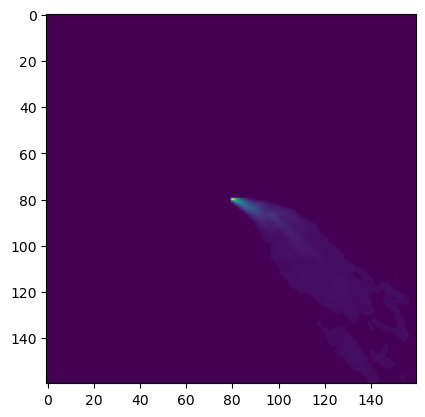

In [17]:
plt.imshow(ds_L.plume[100])

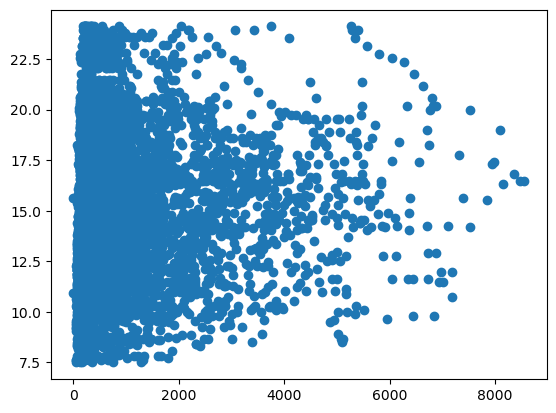

In [11]:
x = np.sum(ds_L.plume, axis=(1,2))
y = ds_L.emiss[:,0]
plt.scatter(x,y)

/cerea_raid/users/dumontj/usr/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


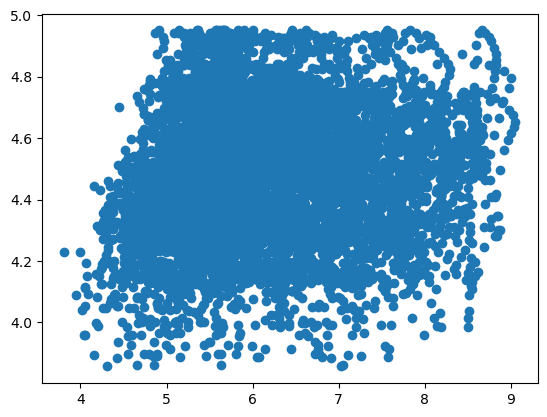

In [6]:
x = np.log(np.sum(ds_L.plume, axis=(1,2)))
y = np.log(np.sum(ds_L.emiss[:,0:6], axis=-1))
plt.scatter(x,y)

## SCENARIO

In [19]:
ds_L_scen = xr.open_dataset("/libre/dumontj/coco2/xco2_emi_scenarii/smart_2km_pLip_nBLip/dataset.nc")

In [20]:
ds_L_scen

<xarray.Dataset>
Dimensions:              (t: 8593, y: 96, x: 96)
Coordinates:
  * t                    (t) datetime64[ns] 2015-01-01 ... 2015-12-25
  * y                    (y) int32 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
  * x                    (x) int32 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
Data variables:
    xco2                 (t, y, x) float32 ...
    plume                (t, y, x) float32 ...
    emiss                (t) float64 ...
    no2                  (t, y, x) float32 ...
    train_valid_bool     (t) bool ...
    test_bool            (t) bool ...
    2d_train_valid_bool  (t) bool ...
    2d_test_bool         (t) bool ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    positivity:   True
    origin:       SMARTCARB

/cerea_raid/users/dumontj/usr/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


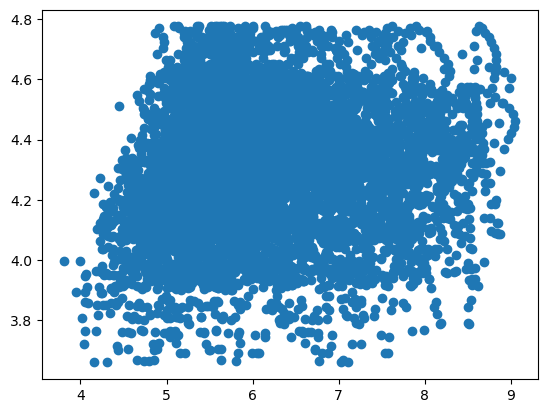

In [ ]:
x = np.log(np.sum(ds_L.plume, axis=(1,2)))
y = np.log(np.sum(ds_L.emiss[:,0:5], axis=-1))
plt.scatter(x,y)

## RAW

In [ ]:
ds_lip = crop_around_source(ds_raw_smartcarb.XCO2_JV[:, :, :], 150, 150, "Lippendorf")
ds_lip = ds_lip.to_dataset()
ds_lip["sum_plume"] = (("t"), np.mean(ds_lip.XCO2_JV.values, axis=(1, 2)) * 100)
ds_lip["max_plume"] = (("t"), np.max(ds_lip.XCO2_JV.values, axis=(1, 2)))

lip_plume_times = ds_lip.t.values
em_lip = pd.DataFrame(emissions["Lippendorf (Mt/yr)"])
em_lip = em_lip[em_lip.index.isin(lip_plume_times)]

ds_lip["emiss"] = (("t"), em_lip["Lippendorf (Mt/yr)"])
ds_lip = ds_lip.where((ds_lip["t.month"] >= 2) & (ds_lip["t.month"] <= 11), drop=True)

In [ ]:
ds_lip.plot.scatter(x="emiss", y="sum_plume")
plt.show()

In [ ]:
sub_ds_lip = ds_lip.where(
    ([i in [0, 4, 8, 12, 16, 20] for i in ds_lip["t.hour"]]) & (ds_lip["t.day"] < 2),
    drop=True,
)
sub_ds_lip.plot.scatter(x="emiss", y="sum_plume")
for i, txt in enumerate(sub_ds_lip["t"].values):
    plt.annotate(
        f"{pd.Timestamp(txt).month:02d}-{pd.Timestamp(txt).day:02d} {pd.Timestamp(txt).hour:02d}h",
        (sub_ds_lip["emiss"][i], sub_ds_lip["sum_plume"][i]),
    )
plt.show()
mean_sum_plume = np.mean(ds_lip["sum_plume"]).values
med_sum_plume = np.median(ds_lip["sum_plume"])
mean_emi = np.mean(ds_lip["emiss"]).values
med_emi = np.median(ds_lip["emiss"])
print(
    "mean sum:",
    mean_sum_plume,
    "median sum:",
    med_sum_plume,
    "mean emi:",
    mean_emi,
    "median emi:",
    med_emi,
)

In [ ]:
# time_pd = "2015-07-01T08"
start = pd.to_datetime("2015-02-01")
end = pd.to_datetime("2015-11-30")

In [ ]:
time_pd = random_dates(start, end).round("H")
print(time_pd)

emiss_t = float(ds_lip.sel(t=pd.Timestamp(time_pd) - pd.Timedelta(hours=0)).emiss)
emiss_t1 = float(ds_lip.sel(t=pd.Timestamp(time_pd) - pd.Timedelta(hours=1)).emiss)
emiss_t3 = float(ds_lip.sel(t=pd.Timestamp(time_pd) - pd.Timedelta(hours=3)).emiss)
emiss_t6 = float(ds_lip.sel(t=pd.Timestamp(time_pd) - pd.Timedelta(hours=6)).emiss)
sum_p = float(ds_lip.sel(t=pd.Timestamp(time_pd)).sum_plume)

In [ ]:
ds_lip_t = ds_lip.sel(t=np.datetime64(pd.Timestamp(time_pd)))

text_plume = (
    f"{time_pd},   \n \n"
    f"rel sum: {sum_p/med_sum_plume:.5f},   \n"
    f"rel emi: {emiss_t/med_emi:.5f},   \n \n"
    f"sum: {sum_p:.5f},   \n \n"
    f"emiss h0: {emiss_t:.2f},   \n"
    f"emiss h-3: {emiss_t3:.2f},   \n"
    f"emiss h-6: {emiss_t6:.2f},   \n"
)

mympf.setMatplotlibParam()
plt.viridis()
axs = mympf.set_figure_axs(1, 1)
im = axs[0].imshow(ds_lip_t.XCO2_JV.values)
plt.colorbar(im, orientation="vertical")
plt.gcf().text(0.95, 0.25, text_plume, fontsize=6)

In [ ]:
sub_ds_lip = ds_lip.where(
    ([i in [0, 4, 8, 12, 16, 20] for i in ds_lip["t.hour"]]) & (ds_lip["t.day"] < 2),
    drop=True,
)
sub_ds_lip.plot.scatter(x="emiss", y="max_plume")
for i, txt in enumerate(sub_ds_lip["t"].values):
    plt.annotate(
        f"{pd.Timestamp(txt).month:02d}-{pd.Timestamp(txt).day:02d} {pd.Timestamp(txt).hour:02d}h",
        (sub_ds_lip["emiss"][i], sub_ds_lip["max_plume"][i]),
    )
plt.show()

In [145]:
mask = (df.index > "2015-11-1") & (df.index <= "2015-11-7")

NameError: name 'df' is not defined

In [ ]:
df.loc[mask].plot(y=["sum_plume"])
df.loc[mask].plot(y=["emiss"])
plt.show()

In [97]:
df.emiss.diff()

UTC
2015-02-01 00:00:00        NaN
2015-02-01 01:00:00   -1.04067
2015-02-01 02:00:00    0.00003
2015-02-01 03:00:00   -0.14855
2015-02-01 04:00:00    0.44634
                        ...   
2015-02-28 19:00:00   -0.32886
2015-02-28 20:00:00   -0.00021
2015-02-28 21:00:00   -0.16450
2015-02-28 22:00:00   -0.82151
2015-02-28 23:00:00   -1.31360
Name: emiss, Length: 672, dtype: float64

In [ ]:



diff_em = em_lip.to_numpy()[first_t+1:] - em_lip.to_numpy()[first_t:-1]
diff_plume = sum_plume.to_numpy()[first_t+1:] - sum_plume.to_numpy()[first_t:-1]

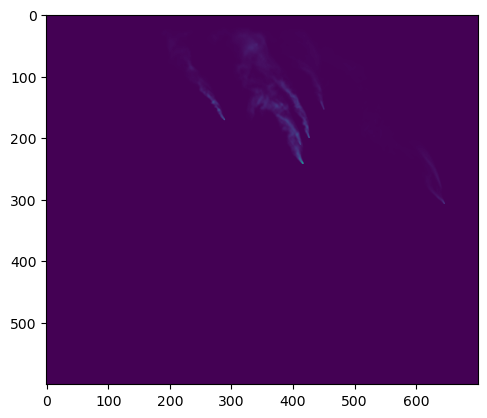

In [26]:
idx = 2300
plt.imshow(ds_raw_smartcarb.XCO2_JV.values[idx])

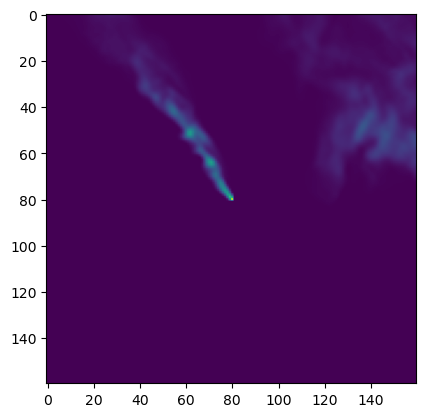

In [27]:
plt.imshow(lippendorf_plume[idx])

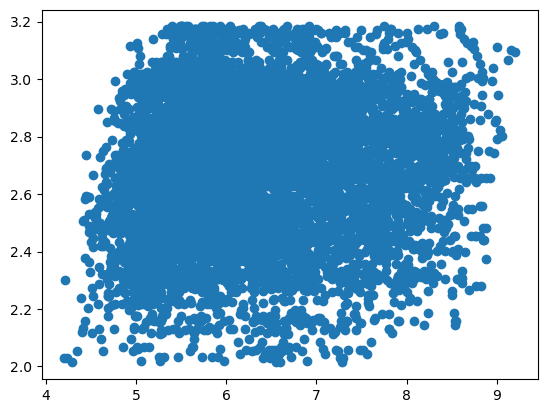

In [82]:
x = np.log(sum_plume)
y = np.log(np.array(em_lip))
plt.scatter(x,y)

In [97]:
diff_plume

array([ 36.702408 ,  -2.1634674, -32.017822 , ...,  20.909912 ,
        -9.956085 , -13.919266 ], dtype=float32)

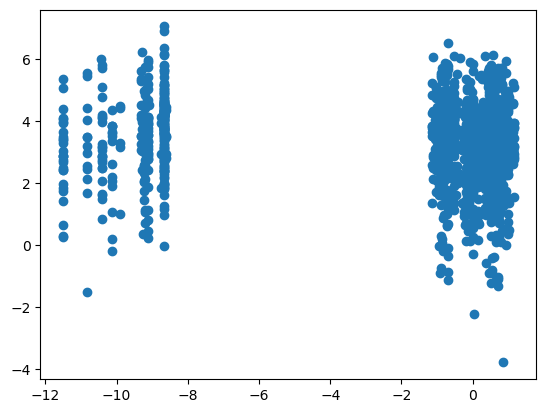

In [99]:
x = np.log(diff_plume)
y = np.log(np.array(diff_em))
plt.scatter(x,y)

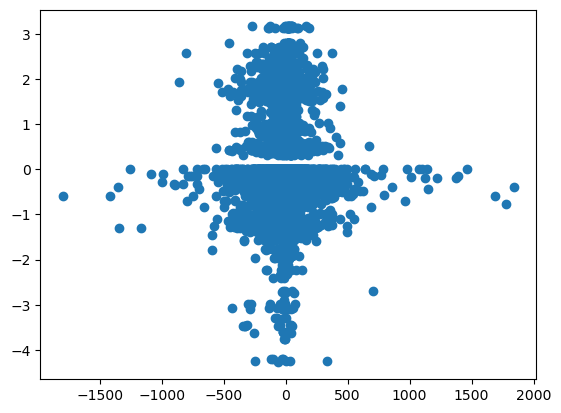

In [100]:
x = diff_plume
y = np.array(diff_em)
plt.scatter(x,y)

# Paris

In [373]:
ds = xr.open_dataset(
    "/libre/dumontj/coco2/raw_data/smartcarb/ERA5/ERA5-lvl-20150207t1900.nc"
)

In [374]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 50, latitude: 27, level: 38, time: 1)
Coordinates:
  * longitude  (longitude) float32 7.5 7.75 8.0 8.25 ... 19.0 19.25 19.5 19.75
  * latitude   (latitude) float32 55.5 55.25 55.0 54.75 ... 49.5 49.25 49.0
  * level      (level) int32 100 101 102 103 104 105 ... 132 133 134 135 136 137
  * time       (time) datetime64[ns] 2015-02-07T19:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-24 09:58:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...